In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
np.set_printoptions(precision=3, suppress=False)

In [2]:
df = pd.read_csv("Fish.csv", index_col=0)

In [3]:
# 5 Data terakhir
df.tail()

,Weight,Length1,Length2,Length3,Height,Width
Species,,,,,,
Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672
Smelt,19.9,13.8,15.0,16.2,2.9322,1.8792


In [4]:
#Hanya angka yang diperlukan
df = df.select_dtypes(exclude=['object'])
df.astype('float64')

,Weight,Length1,Length2,Length3,Height,Width
Species,,,,,,
Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558


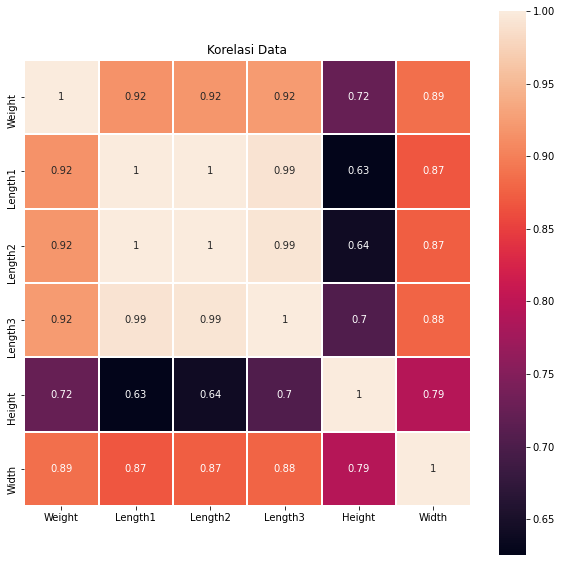

In [5]:
#Hitung korelasi datanya
plt.figure(figsize=(10,10))
plt.title("Korelasi Data")
sns.heatmap(df.corr(), square=True, annot=True, vmax=1, linewidths=1, linecolor='white')

In [6]:
df ['Average Length'] = df['Length1'] + df['Length2'] + df['Length3'] /3
df = df.drop(['Length1','Length2','Length3'], axis=1)

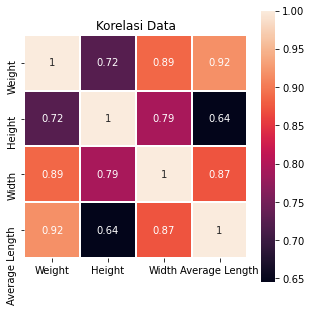

In [7]:
df.head()
plt.figure(figsize=(5,5))
plt.title("Korelasi Data")
sns.heatmap(df.corr(), square=True, annot=True, vmax=1, linewidths=1, linecolor='white')

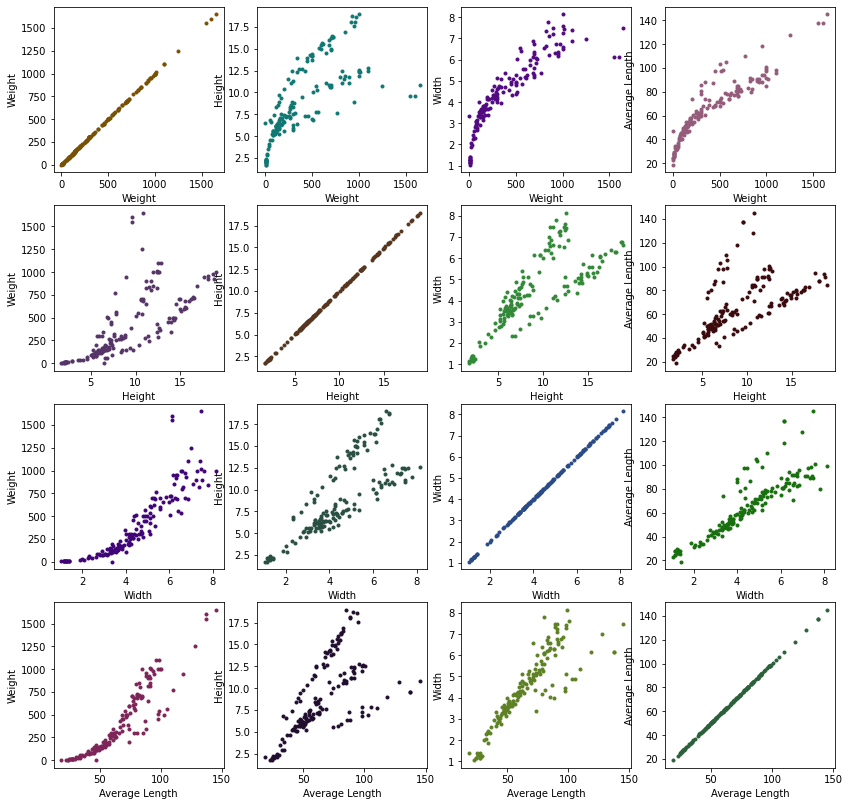

In [8]:
list_parameter = ['Weight','Height','Width','Average Length']
figure, axis = plt.subplots(len(list_parameter),len(list_parameter), figsize=(14,14))
for i in range(len(list_parameter)):
    for j in range(len(list_parameter)):
        axis[i,j].plot(df[list_parameter[i]], df[list_parameter[j]], '.', c=[random.random()*0.6,random.random()*0.6,random.random()*0.6])
        axis[i,j].set_xlabel(list_parameter[i])
        axis[i,j].set_ylabel(list_parameter[j])

plt.show()


# Pytorch
## Memprediksi Berat Ikan dengan Pytorch

Dalam hal ini, kita menggunakan pendekatan iteratif seperti yang sudah dibuktikan sebelumnya.

- Nilai input x adalah ketiga parameter selain berat ikan 
- Nilai input y adalah berat ikan (Weight)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

### Menentukan Bentuk Model

Karena kita dapat mengamati dari grafik bahwa ketiga variabel selain berat ikan memiliki relasi kuadrat dan grafik melewati titik origin (0,0), model persamaan dapat kita tuliskan $ y= ax_{1}^{2} + b x_{2}^{2} + c x_{3}^{2} $ dengan $y$ sebagai Weight dari ikan, $ x_{1} , x_{2} , x_{3} $ sebagai Height, Width, dan Average Length dan $ a , b , c $ sebagai koefisien/bobot model yang ingin kita cari 

In [11]:
X = df[['Height','Width','Average Length']].values

X = X**2 #Setiap data input dikuadratkan seperti model


In [12]:
Y = df['Weight'].values #Output adalah prediksi berat

In [13]:
m = len(Y) #Jumlah data
n = len(X[0]) #Jumlah parameter
X_tensor = torch.from_numpy(X.reshape( m, n)).float() #Membuat tensor dari data input
Y_tensor = torch.from_numpy(Y.reshape( m, 1)).float() #Membuat tensor dari data output

In [14]:
print(X_tensor.shape)
print(Y_tensor.shape)

torch.Size([159, 3])
torch.Size([159, 1])


Mari kita definisikan dulu model Regresi Linear Pytorch

In [15]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

Atur Learning Rate yang tidak terlalu besar dan tidak terlalu kecil. Kalau terlalu besar, hasil regresi akan divergen. Jika terlalu kecil, hasil regresi terlalu lama konvergen.

In [16]:
learningRate = 1e-8
epochs = 1000

model = LinearRegression(n, 1)

if torch.cuda.is_available():
    model = model.cuda()

Gunakan Fungsi Loss Mean-Squared Error dan Optimizer Single Gradient Descent.

In [17]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), learningRate)


Mari melatih model dengan data yang kita miliki

In [18]:
for epoch in range(epochs):
    if torch.cuda.is_available():
        inputs = X_tensor.cuda()
        targets = Y_tensor.cuda()
    else:
        inputs = X_tensor
        targets = Y_tensor
    
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 25 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

Epoch [25/1000], Loss: 19253.7168
Epoch [50/1000], Loss: 19207.8242
Epoch [75/1000], Loss: 19162.2363
Epoch [100/1000], Loss: 19116.9551
Epoch [125/1000], Loss: 19071.9707
Epoch [150/1000], Loss: 19027.2910
Epoch [175/1000], Loss: 18982.9062
Epoch [200/1000], Loss: 18938.8164
Epoch [225/1000], Loss: 18895.0195
Epoch [250/1000], Loss: 18851.5156
Epoch [275/1000], Loss: 18808.3008
Epoch [300/1000], Loss: 18765.3711
Epoch [325/1000], Loss: 18722.7344
Epoch [350/1000], Loss: 18680.3730
Epoch [375/1000], Loss: 18638.3008
Epoch [400/1000], Loss: 18596.5039
Epoch [425/1000], Loss: 18554.9863
Epoch [450/1000], Loss: 18513.7441
Epoch [475/1000], Loss: 18472.7793
Epoch [500/1000], Loss: 18432.0840
Epoch [525/1000], Loss: 18391.6621
Epoch [550/1000], Loss: 18351.5098
Epoch [575/1000], Loss: 18311.6211
Epoch [600/1000], Loss: 18272.0000
Epoch [625/1000], Loss: 18232.6445
Epoch [650/1000], Loss: 18193.5469
Epoch [675/1000], Loss: 18154.7129
Epoch [700/1000], Loss: 18116.1387
Epoch [725/1000], Loss:

In [19]:
coef = model.linear.cpu().weight.data.numpy()[0]
print("Persamaan akhirnya adalah: y = {:.2f} x1^2 + {:.2f} x2^2 + {:.2f} x3^2".format(coef[0], coef[1], coef[2]))
model.linear.cpu().weight.data

Persamaan akhirnya adalah: y = 0.24 x1^2 + -0.24 x2^2 + 0.08 x3^2


tensor([[ 0.2430, -0.2386,  0.0823]])

In [20]:
output_df = pd.DataFrame()
output_df['Height'] = df['Height']
output_df['Width'] = df['Width']
output_df['Average Length'] = df['Average Length']
output_df['Actual Weight'] = df['Weight']
output_df['Predicted Weight'] = coef[0]*output_df['Height']**2 + coef[1]*output_df['Width']**2 + coef[2]*output_df['Average Length']**2

In [21]:
output_df.head()

,Height,Width,Average Length,Actual Weight,Predicted Weight
Species,,,,,
Bream,11.5200,4.0200,58.600000,242.0,310.869291
Bream,12.4800,4.3056,60.700000,290.0,336.509322
Bream,12.3778,4.6961,60.766667,340.0,335.719251
Bream,12.7300,4.4555,66.466667,363.0,398.050599
Bream,12.4440,5.1340,66.833333,430.0,398.768889


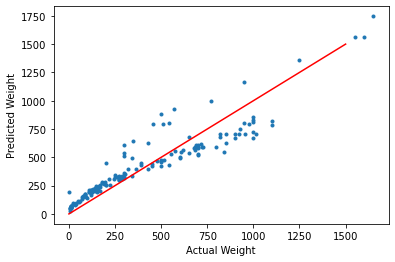

In [22]:
plt.plot(output_df['Actual Weight'], output_df['Predicted Weight'], '.')
plt.plot([0,1500],[0,1500], 'r-')
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.show()

Kita ambil Contoh Data yang ingin kita prediksi

In [39]:
pred_df = pd.DataFrame()
pred_df['Height'] = [10,12,13,14, 15, 11.5200]
pred_df['Width'] = [3,4,5,6,7, 4.0200]
pred_df['Average Length'] = [55, 57, 59, 61, 63, 58.600000]
pred_df[['Height^2','Width^2','Average Length^2']] = pred_df[['Height','Width','Average Length']].apply(lambda x: x**2)
df[['Height','Width','Average Length']].values
with torch.no_grad():
    pred_df['Weight Prediction'] = model(torch.from_numpy( pred_df[['Height^2','Width^2','Average Length^2']].values).float()).data.numpy()


pred_df.tail()

,Height,Width,Average Length,Height^2,Width^2,Average Length^2,Weight Prediction
1,12.00,4.00,57.0,144.0000,16.0000,3249.00,298.785797
2,13.00,5.00,59.0,169.0000,25.0000,3481.00,321.797607
3,14.00,6.00,61.0,196.0000,36.0000,3721.00,345.476257
4,15.00,7.00,63.0,225.0000,49.0000,3969.00,369.821747
5,11.52,4.02,58.6,132.7104,16.1604,3433.96,311.218689
